# Big Arrays, Fast: Profiling Cloud Storage Read Throughput

By [Ryan Abernathey](https://github.com/rabernat)

## Introduction

Many geoscience problems involve analyzing hundreds of Gigabytes (GB), many Terabytes (TB = 100 GB), or even a Petabyte (PB = 1000 TB) of data.
For such data volumes, downloading data to personal computers is inefficient.
Data-proximate computing, possibly using a parallel computing cluster, is one way to overcome this challenge.
With data-proximate computing, a user access a remote computer which is connected tightly to shared, high-performance storage, enabling rapid processing without the need for a download step.

<img width="400px" src="https://ndownloader.figshare.com/files/22017009/preview/22017009/preview.jpg"/>

Figure from _Data Access Modes in Science_, by Ryan Abernathey. http://dx.doi.org/10.6084/M9.FIGSHARE.11987466.V1


The cloud offers many exciting new possibilities for scientific data analysis.
It also brings new technical challenges.
Many scientific users are accustomed to the environments found on High-Performance Computing (HPC) systems, such as NSF's XSEDE Computers or NCAR's Cheyenne system.
These systems combine parallel computing with a high-performance shared filesystem, enabling massively parallel data analytics.
When shifting workloads to the cloud, one of the biggest challenges is how to store data: _cloud computing does not easily support large shared filesystems, as commonly found on HPC systems_.
The preferred way to store data in the cloud is using _cloud object storage_, such as Amazon S3 or Google Cloud Storage.

<img width="400px" src="https://assets.ubuntu.com/v1/09b510e0-UAS_storage_options.png">

_Image via [Ubuntu Website](https://ubuntu.com/blog/what-are-the-different-types-of-storage-block-object-and-file), ©2020 Canonical Ltd. Ubuntu, Used with Permission_


Cloud object storage is essentially a key/value storage system.
They keys are strings, and the values are bytes of data.
Data is read and written using HTTP calls.
The performance of object storage is very different from file storage.
On one hand, each individual read / write to object storage has a high overhead (10-100 ms), since it has to go over the network.
On the other hand, object storage "scales out" nearly infinitely, meaning that we can make hundreds, thousands, or millions of concurrent reads / writes.
This makes object storage well suited for distributed data analytics.
However, the software architecture of a data analysis system must be adapted to take advantage of these properties.

The goal of this notebook is to demonstrate one software stack that can effectively exploit the scalable nature of cloud storage and computing for data processing. There are three key elements:

- [Zarr](http://zarr.readthedocs.io/) - a library for the storage of multi-dimensional arrays using compressed chunks.
- [Filesystem Spec](https://filesystem-spec.readthedocs.io/) - an abstraction layer for working with different storage technologies. Specific implementations of filesystem spec (e.g. [gcsfs](https://gcsfs.readthedocs.io/), Google Cloud Storage Filesystem) allow Zarr to read and write data from object storage.
- [Dask](http://dask.pydata.org/) - a distributed computing framework that allows us to read and write data in parallel asynchronously.


## Accessing the Data

For this demonstration, we will use data stored in Google Cloud Storage.
The data come from the [GFDL CM2.6 high-resolution climate model](https://www.gfdl.noaa.gov/cm2-6/).
They are catalogged on the Pangeo Cloud Data Catalog here:

- https://catalog.pangeo.io/browse/master/ocean/GFDL_CM2_6/

The catalog returns an [http://xarray.pydata.org/](Xarray) object pointing to the data on google cloud:

In [1]:
import time
from contextlib import contextmanager

import dask
import dask.array as dsa
import fsspec
import intake
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from intake import open_catalog

cat = open_catalog(
    "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml"
)
item = cat["GFDL_CM2_6_control_ocean"]
ds = item.to_dask()
ds

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


<xarray.Dataset>
Dimensions:            (nv: 2, st_edges_ocean: 51, st_ocean: 50, sw_edges_ocean: 51, sw_ocean: 50, time: 240, xt_ocean: 3600, xu_ocean: 3600, yt_ocean: 2700, yu_ocean: 2700)
Coordinates:
    geolat_c           (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_c           (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * nv                 (nv) float64 1.0 2.0
  * st_edges_ocean     (st_edges_ocean) float64 0.0 10.07 ... 5.29e+03 5.5e+03
  * st_ocean           (st_ocean) float64 5.034 15.1 ... 5.185e+03 5.395e+03
  * sw_edges_ocean     (sw_edges_ocean) float64 5.034 15.1 ... 5.395e+03 5.5e+03
  * sw_ocean           (sw_ocean) float64 10.07 20.16 30.29 ... 5.29e+03 5.5e+03
  * time               (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xt_ocean           (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * xu_ocean           (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.9 80.0
  * yt_ocean           (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
  * yu_ocean           (yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.96 90.0
Data variables:
    average_DT         (time) timedelta64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
    average_T1         (time) object dask.array<chunksize=(12,), meta=np.ndarray>
    average_T2         (time) object dask.array<chunksize=(12,), meta=np.ndarray>
    eta_t              (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    eta_u              (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    frazil_2d          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    hblt               (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    ice_calving        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    mld                (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    mld_dtheta         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    net_sfc_heating    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    pme_river          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    pot_rho_0          (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    river              (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    salt               (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    salt_int_rhodz     (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    sea_level          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    sea_levelsq        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    sfc_hflux_coupler  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    sfc_hflux_pme      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    swflx              (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    tau_x              (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    tau_y              (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    temp               (time, st_ocean, yt_ocean, xt_ocean) float32 

For this example, we are not interested in Xarray's advanced data analytics features, so we will work directly with the raw array data. Here we examine the data from the `temp` variable (ocean temperature):

In [3]:
data = ds.temp.data
data

,Array,Chunk
Bytes,466.56 GB,194.40 MB
Shape,"(240, 50, 2700, 3600)","(1, 5, 2700, 3600)"
Count,2401 Tasks,2400 Chunks
Type,float32,numpy.ndarray


Before dropping down to the dask level, we take a quick peek at the data using Xarray's built-in visualization capabilities.

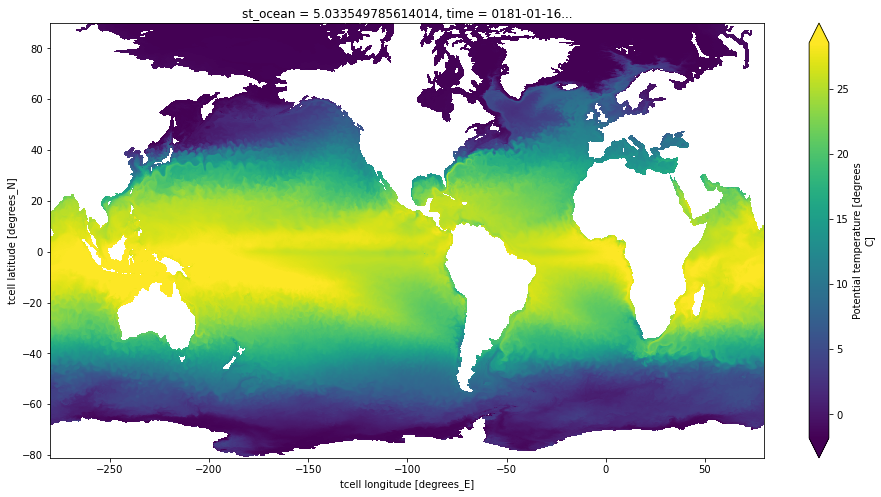

In [4]:
ds.temp[0, 0].plot(figsize=(16, 8), center=False, robust=True)

_Side note:_ We can open this array directly with dask, bypassing xarray, if we know the path on the object store.
(These give identical results.)

In [5]:
item.urlpath

'gs://cmip6/GFDL_CM2_6/control/ocean'

In [6]:
dsa.from_zarr(fsspec.get_mapper("gs://cmip6/GFDL_CM2_6/control/ocean/temp"))

,Array,Chunk
Bytes,466.56 GB,194.40 MB
Shape,"(240, 50, 2700, 3600)","(1, 5, 2700, 3600)"
Count,2401 Tasks,2400 Chunks
Type,float32,numpy.ndarray


Some important observations:

- The data is organized into 2400 distinct chunks--each one corresponds to an individual object in Google Cloud Storage
- The in-memory size of each chunk is 194.4 MB
- The chunks are contiguous across the latitude and longitude dimensions (axes 2 and 3) and span 5 vertical levels (axis 1). Each timestep (axis 0) is in a different chunk. 
- Zarr + Dask know how to virtually combine these chunks into a single 4-dimensional array.

## Set Up Benchmarking

Now we want to see how fast we can load data from the object store. _We are not interested in any computations._ Here the goal is simply to measure read performance and how it scales. In order to do this, we  employ a trick: we  store the data into a virtual storage target that simply discards the data, similar to piping data to `/dev/null` on a filesystem.

To do this, we define the following storage class:

In [7]:
class DevNullStore:
    def __init__(self):
        pass

    def __setitem__(*args, **kwargs):
        pass

This is basically a dictionary that forgets whatever you put in it:

In [8]:
null_store = DevNullStore()
# this line produces no error but actually does nothing
null_store['foo'] = 'bar'

Now let's see how long it takes to store one chunk of data into this null storage target.
This essentially measures the read time.

In [9]:
%time dsa.store(data[0, :5], null_store, lock=False)

CPU times: user 869 ms, sys: 367 ms, total: 1.24 s
Wall time: 1.31 s


Now we want to scale this out to see how the read time scales as a function of number of parallel reads.
For this, we need a Dask cluster.
In our Pangeo environment, we can use [Dask Gateway](https://medium.com/pangeo/pangeo-with-dask-gateway-4b638825f105) to create a Dask cluster.
But there is an analogous way to do this on nearly any distributed computing environment.
HPC-style environments (PBS, Slurm, etc.) are supported via [Dask Jobqueue](http://jobqueue.dask.org/en/latest/).
Most cloud environments can work with [Dask Kubernetes](https://kubernetes.dask.org/en/latest/).

In [10]:
from dask.distributed import Client
from dask_gateway import Gateway

gateway = Gateway()
cluster = gateway.new_cluster()
cluster

In [11]:
client = Client(cluster)
client

Client Scheduler: gateway://traefik-prod-dask-gateway.prod:80/prod.60e3f302262e4bf18407b37fcde32296 Dashboard: https://hub.binder.pangeo.io/services/dask-gateway/clusters/prod.60e3f302262e4bf18407b37fcde32296/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


Finally we create a context manager to help us keep track of the results of our benchmarking

In [12]:
class DiagnosticTimer:
    def __init__(self):
        self.diagnostics = []

    @contextmanager
    def time(self, **kwargs):
        tic = time.time()
        yield
        toc = time.time()
        kwargs["runtime"] = toc - tic
        self.diagnostics.append(kwargs)

    def dataframe(self):
        return pd.DataFrame(self.diagnostics)


diag_timer = DiagnosticTimer()

## Do Benchmarking

We want to keep track of some information about our array.
Here we figure out the size (in bytes) of the chunks.

In [13]:
chunksize = np.prod(data.chunksize) * data.dtype.itemsize
chunksize

194400000

And about how many workers / threads are in the cluster.
The current cluster setup uses two threads and approximately 4 GB of memory per worker.
These settings are the defaults for the current Pangeo environment and have not been explored extensively.
We do not expect high sensitivity to these parameters here, as the task is I/O limited, not CPU limited.

In [14]:
def total_nthreads():
    return sum([v for v in client.nthreads().values()])


def total_ncores():
    return sum([v for v in client.ncores().values()])


def total_workers():
    return len(client.ncores())

This is the main loop where we time a distributed read for different numbers of worker counts.
We also keep track of some other metadata about our testing conditions.

In [15]:
diag_kwargs = dict(nbytes=data.nbytes, chunksize=chunksize, cloud='gcloud', format='zarr')


for nworkers in [30, 20, 10, 5]:
    cluster.scale(nworkers)
    time.sleep(10)
    client.wait_for_workers(nworkers)
    print(nworkers)
    with diag_timer.time(nthreads=total_nthreads(), ncores=total_ncores(), nworkers=total_workers(), **diag_kwargs):

        future = dsa.store(data, null_store, lock=False, compute=False)
        dask.compute(future, retries=5)

30


20


10


5


In [16]:
client.close()
cluster.close()

In [17]:
df = diag_timer.dataframe()
df

,nthreads,ncores,nworkers,nbytes,chunksize,cloud,format,runtime
0,60,60,30,466560000000,194400000,gcloud,zarr,117.696347
1,40,40,20,466560000000,194400000,gcloud,zarr,156.934256
2,20,20,10,466560000000,194400000,gcloud,zarr,211.342585
3,10,10,5,466560000000,194400000,gcloud,zarr,414.379612


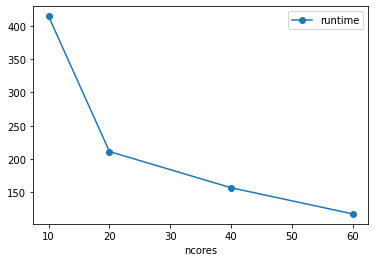

In [18]:
df.plot(x='ncores', y='runtime', marker='o')

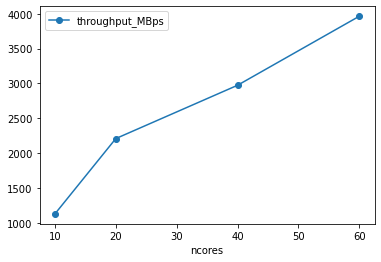

In [19]:
df['throughput_MBps'] = df.nbytes / 1e6 / df['runtime']
df.plot(x='ncores', y='throughput_MBps', marker='o')

(0.0, 100.0)

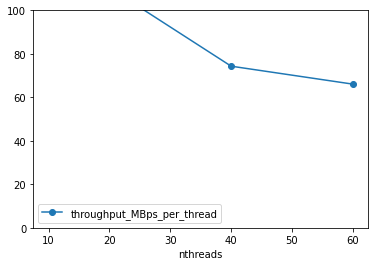

In [20]:
df['throughput_MBps_per_thread'] = df.throughput_MBps / df.nthreads
df.plot(x='nthreads', y='throughput_MBps_per_thread', marker='o')
plt.ylim([0, 100])

## Compare Many Results

Similar tests to the one above were performed with many different cloud storage technologies and data formats:

- Google Cloud Storage + Zarr Format (like the example above)
- Google Cloud Storage + NetCDF Format (NetCDF files were opened directly from object storage using `gcsfs` to provide file-like objects to `h5py`)
- [Wasabi Cloud](https://wasabi.com/) + Zarr Format (A discount cloud-storage vendor)
- [Jetstream Cloud](http://jetstream-cloud.org/) + Zarr Format (NSF's Cloud)
- [Open Storage Network](https://www.openstoragenetwork.org/) (OSN) NCSA Storage Pod + Zarr Format
- The [NASA ECCO Data Portal](https://data.nas.nasa.gov/ecco) (data read using [`xmitgcm.llcreader`](https://xmitgcm.readthedocs.io/en/latest/llcreader.html))
- Various OPeNDAP Servers, including:
  - The [UCAR ESGF Node](https://esgf-data.ucar.edu/thredds/catalog/catalog.html) TDS Server
  - [NOAA ESRL PSL](https://psl.noaa.gov/thredds/catalog.html) TDS Server

The results have been archived on Zenodo:
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.3829032.svg)](https://doi.org/10.5281/zenodo.3829032)

Despite the different sources and formats, all tests were conducted in the same basic manner:
1. A "lazy" dask array referencing the source data was created
2. A dask cluster was scaled up to different sizes
3. The array was "stored" into the `NullStore`, forcing all data to read from the source

_Note:_ All computing was done in Google Cloud.

In [21]:
url_base = 'https://zenodo.org/record/3829032/files/'
files = {
    'GCS Zarr': [
        'gcloud-test-1.csv',
        'gcloud-test-3.csv',
        'gcloud-test-4.csv',
        'gcloud-test-5.csv',
        'gcloud-test-6.csv',
    ],
    'GCS NetCDF': ['netcdf-test-1.csv'],
    'Wasabi Zarr': ['wasabi-test-1.csv', 'wasabi-test-2.csv', 'wasabi-test-3.csv'],
    'Jetstream Zarr': ['jetstream-1.csv', 'jetstream-2.csv'],
    'ECCO Data Portal': ['ecco-data-portal-1.csv', 'ecco-data-portal-2.csv'],
    'ESGF UCAR OPeNDAP': ['esgf-ucar-1.csv', 'esgf-ucar-2.csv'],
    'NOAA ESRL OPeNDAP': ['noaa-esrl-1.csv', 'noaa-esrl-2.csv'],
    'OSN Zarr': ['OSN-test-1.csv', 'OSN-test-2.csv'],
}

data = {}
for name, fnames in files.items():
    data[name] = pd.concat([pd.read_csv(f'{url_base}/{fname}') for fname in fnames])

In [22]:
data['OSN Zarr']

,Unnamed: 0,operation,nbytes,cloud,region,nthreads,ncores,nworkers,runtime,throughput_MBps
0,0,load,466560000000,OSN,ncsa,52,52,26,81.508533,5724.063287
1,1,load,466560000000,OSN,ncsa,56,56,28,74.447608,6266.957584
2,2,load,466560000000,OSN,ncsa,56,56,28,76.227204,6120.649557
0,0,load,466560000000,OSN,ncsa,176,176,88,90.225218,5171.059835
1,1,load,466560000000,OSN,ncsa,176,176,88,87.946760,5305.027713
2,2,load,466560000000,OSN,ncsa,176,176,88,85.846841,5434.795231
3,3,load,466560000000,OSN,ncsa,118,118,59,86.004042,5424.861286
4,4,load,466560000000,OSN,ncsa,116,116,58,84.333328,5532.332396
5,5,load,466560000000,OSN,ncsa,56,56,28,78.459454,5946.510916
6,6,load,466560000000,OSN,ncsa,58,58,29,79.128673,5896.219217


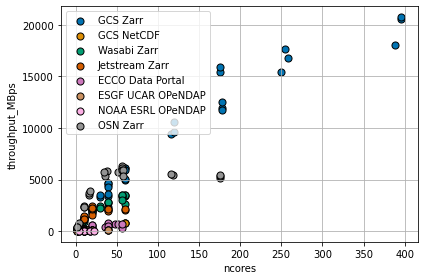

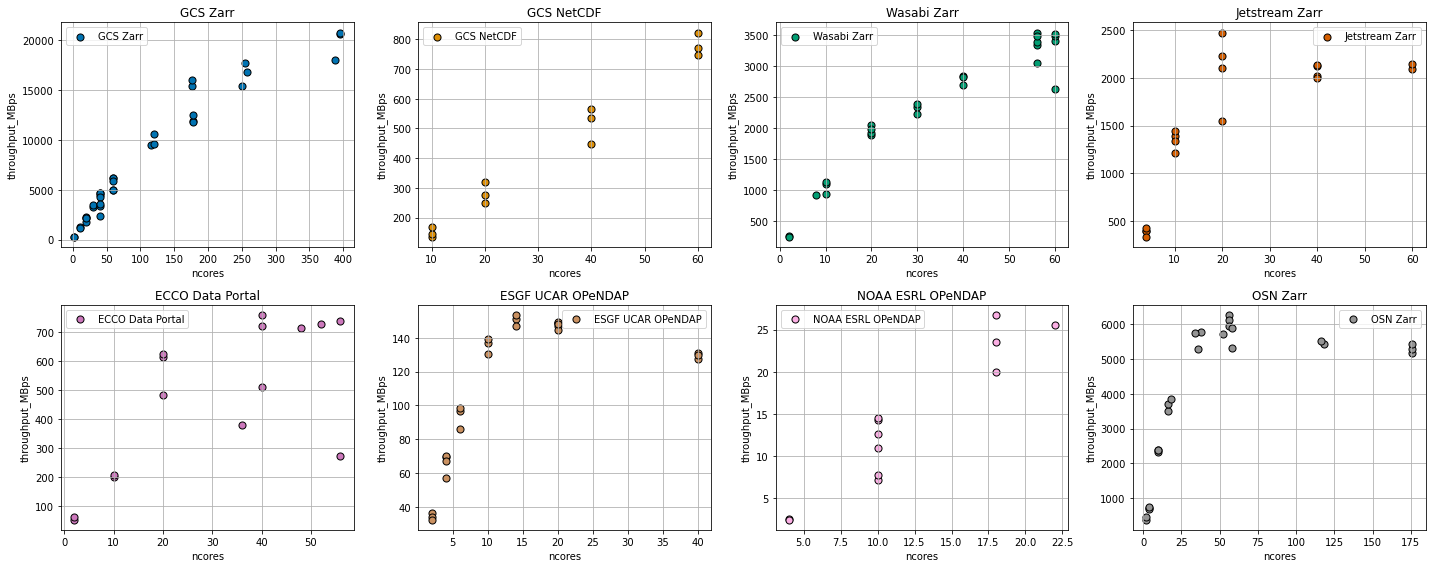

In [23]:
fig0, ax0 = plt.subplots()
fig1, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
palette = sns.color_palette('colorblind', len(files))

for (name, df), color, ax1 in zip(data.items(), palette, axs.flat):
    for ax in [ax0, ax1]:
        df.plot(
            kind='scatter',
            x='ncores',
            y='throughput_MBps',
            s=50,
            c=[color],
            edgecolor='k',
            ax=ax,
            label=name,
        )
    ax1.grid()
    ax1.set_title(name)

ax0.grid()
ax0.legend(loc='upper left')

fig0.tight_layout()
fig1.tight_layout()

## Discussion

The figure above shows a wide range of throughput rates and scaling behavior.
There are a great many factors which might influence the results, including:
- The structure of the source data (e.g. data format, chunk size, compression, etc.)
- The rate at which the storage service can read and process data from its own disks
- The transport protocol and encoding (compression, etc.)
- The network bandwidth between the source and Google Cloud US-CENTRAL1 region
- The overhead of the dask cluster in computing many tasks simultaneously

The comparison is far from "fair": it is clearly biased towards Google Cloud Storage, which has optimum network proximity to the compute location. Nevertheless, we make the following observations.

### Zarr is about 10x faster than NetCDF in Cloud Object Storage

Using 40 cores (20 dask workers), we were able to pull netCDF data from Google Cloud Storage at a rate of about 500 MB/s.
Using the Zarr format, we could get to 5000 MB/s (5 GB/s) for the same number of dask workers.

### Google Cloud Storage Scales

Both formats, however, showed good scaling, with throughput increasingly nearly linearly with the size of the cluster.
The largest experiment we attempted used nearly 400 cores: we were able to pull data from GCS at roughly 20 GB/s.
That's pretty fast! At this rate, we could process a Petebyte of data in about 14 hours.
However, there is a knee in the GCS-Zarr curve around 150 cores, with the scaling becoming slightly poorer above that value.
We hypothesize that this is due to Dask's overhead from handling a very large task graph.

### External Cloud Storage Providers Scale...then Saturate

We tested three cloud storage providers _outside_ of Google Cloud: Wasabi (a commercial service), Jetstream (an NSF-operated cloud), and OSN (an NSF-sponsored storage provider).
These curves all show a similar pattern: good scaling for low worker counts, then a plateau.
We interpret this a saturation of the network bandwidth between the data and the compute location.
Of these three, Jetstream saturated at the lowest value (2 GB/s), then Wasabi (3.5 GB/s, but possibly not fully saturated yet), then OSN (5.5 GB/s).
Also noteworthy is the fact that, for smaller core counts, OSN was actually _faster_ than GCS _within Google Cloud_.
These results are likely highly sensitive to network topology.
However, they show unambiguously that OSN is an attractive choice for cloud-style storage and on-demand big-data processing.

### OPeNDAP is Slow

The fastest we could get data out of an OPeNDAP server was 100 MB/s (UCAR ESGF Node).
The NOAA ESRL server was more like 20 MB/s.
These rates are many orders of magnitude than cloud storage.
Perhaps these servers have throttling in place to limit their total bandwidth.
Or perhaps the OPeNDAP protocol itself has some fundamental inefficiencies.
OPeNDAP remains a very convenient protocol for remote data access; if we wish to use it for Big Data and distributed processing, data providers need to find some way to speed it up.

## Conclusions

We demonstrated a protocol for testing the throughput and scalability Array data storage with the Dask computing framework.
Using Google Cloud as our compute platform, we found, unsurprisingly, that a cloud-optimized storage format (Zarr), used with in-region cloud storage, provided the best raw throughput (up to 20 GB/s in our test) and scalability.
We found that the same storage format also allowed us to transfer data on-demand from other clouds at reasonable rates (5 GB/s) for modest levels of parallelism.
(Care must be taken in this case, however, because many cloud providers charge egress fees for data leaving their network.)
Combined with Zarr, all of the cloud object storage platforms were able to deliver data orders of magnitude faster than traditional OPeNDAP servers, the standard remote-data-access protocol for the geosciences.

### Future Work

This analysis could be improved in numerous ways. In the future we would like to
- Investigate other cloud-native storage formats, such as TileDB and Cloud-Optimized Geotiff
- Perform deeper analysis of parameter sensitivity (chunk size, compression, etc.)
- Explore other clouds (e.g. AWS, Microstoft Azure)

Finally, we did not attempt to assess the relative costs associated with cloud vs. on-premises data storage, as this involves difficult questions related to total cost of ownership.
However, we hope these results are useful for data providers in deciding how to provision future infrastructure for data-intensive geoscience.

## Notebook Reviews

Here we include the review of the original version of this notebook and our replies.

### Review 1
 
#### Evaluation of the Contribution
Overall Recommendation (100%): 9
Total points (out of 10)    : 9


#### Comments for the Authors
"Big Arrays, Fast: Profiling Cloud Storage Read Throughput" is a good quality
and, most of all, interesting science meets computer science notebook. It
addresses important issues relevant to this scientific arena. The problem
statement, discussion and conclusions are all compelling and pertinent to this
area of inquiry.

The most important criterion "does it run" is satisfied as I was able to run
the notebook to completion on https://ocean.pangeo.io (though I could not run
it on Binder for some reason, "KeyError: 'GFDL_CM2_6_control_ocean'").

> The error has been corrected in the current version.

I especially liked this notebook for the following reason:

- The "computational essay" aspect receives high marks for having expository
prose and computation work together to build a logical conclusion.
- Figures are generated inline with matplotlib
- Figures are easy to understand and interesting (e.g., the set of throughput
figures at the end of the notebook).
- The xarray.Dataset meta data allows for inspection via the attributes and
data representation icons.
- Computational cells are small and intermixed with expository prose.

Problems with this notebook:

- Quite a few distracting spelling errors: Benachmarks, analagous, simultaneouslly, slighly, saturdation

> Unfortunately, JupyterLab has no spell checker, a feature I have obviously become to reliant upon.

A suggestion for improvement would be to include a reference section with HTML
linked DOIs for further inquiry and background material, and perhaps also a
future work section.

> A future work section has been included.


### Review 2

#### Evaluation of the Contribution

Overall Recommendation (100%): 8
Total points (out of 10)    : 8


#### Comments for the Authors

- the author should add to the discussion a reason for the choice of threads,
cores and workers in the 'do benchmarking' section

> This has been done

- while the analysis is designed to provide a coarse grain view of the speed
of zarr, it might be a valuable exercise to break the scales down to segments
where they can be compared; e.g. of the four zarr tests, the n_cores scales
vary from 0..400 (gcs), 0..60 (wasabi, jetstream) and 0..175 (osn) and thus
these scales make it difficult to compare them when we do not have data past
n_cores=60 and again n_cores=175

> This a reasonable suggestion but beyond what we could accomplish in a brief revision period.

- though the authors acknowledge the tests are not 'fair', indeed it would be
more valuable to compare various configurations of netcdf to make such
comparisons more easily interpretable

> It's not clear what other "configurations" of netCDF are being suggested here. 

- typo: change to "saturation" > We interpret this a saturdation of the
network bandwidth between the data and the compute location.

> Thanks, done.

- the abstract should include "preliminary" to situate this work as
in-progress and not a full quantitative exploration and assessment of
accessing data

> Given the combinatoric explosion of possible configuration choices, is a comprehensive "full quantitative exploration" even possible?

- if at all possible the author should provide instructions for how to execute
elsewhere outside the pangeo platform


> We have included some new links to how to deploy dask in other environments.

- licensing information as well as notebook requirements should also be
provided with the notebook (or a link to the GH repo if one exists for the
notebook)

> This was all included in the original submission.